In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from typing import Dict
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from stformer import logger
from stformer.tokenizer import GeneVocab
from stformer.tokenizer import tokenize_and_pad_batch

In [2]:
class SlideData():
    def __init__(self, data_path, slide, vocab, pad_value, pad_token):
        self.data_path = data_path
        self.slide = slide
        self.vocab = vocab
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()
    
    def load_data(self):
        adata = sc.read_h5ad(f'{self.data_path}/{self.slide}_Visium_deconv.h5ad')

        scfoundation_gene_df = pd.read_csv(f'{tokenizer_dir}/scfoundation_gene_df.csv')
        scfoundation_gene_df.set_index('gene_ids', inplace=True)
        total_gene_num = adata.shape[1]
        adata = adata[:, adata.var_names.isin(scfoundation_gene_df.index)]
        adata.var['gene_name'] = scfoundation_gene_df.loc[adata.var_names, 'gene_symbols'].values
        seleted_gene_num = adata.shape[1]
        genes = adata.var["gene_name"].tolist()
        gene_ids = np.array(self.vocab(genes), dtype=int)

        logger.info(
            f"match {seleted_gene_num}/{total_gene_num} genes "
            f"in vocabulary of size 19264."
        )

        ligand_database = pd.read_csv(tokenizer_dir+'ligand_database.csv', header=0, index_col=0)
        ligand_symbol = ligand_database[ligand_database.sum(1)>1].index.values
        ligand_ids = self.vocab(ligand_symbol.tolist())
        adata = adata[(adata[:,adata.var['gene_name'].isin(ligand_symbol)].X.sum(1)>0).A.T[0],:]
            
        celltype_proportion = adata.obsm['q05_cell_abundance_w_sf']
        celltype_proportion.rename(columns=lambda x: x[23:], inplace=True)
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)
        celltype_proportion[celltype_proportion < 0.05] = 0
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)

        for celltype in adata.layers.keys():
            adata.X = adata.layers[celltype]
            sc.pp.normalize_total(adata, target_sum=1e4)
            sc.pp.log1p(adata)
            adata.uns.pop('log1p')
            adata.layers[celltype] = adata.X

        self.adata = adata
        self.celltype_proportion = celltype_proportion
        self.gene_ids = gene_ids
        self.ligand_ids = ligand_ids
    
    def get_niche_samples(self):
        samples_expression = []
        samples_ctprop = []
        celltypes_labels = []
        for i in range(self.adata.shape[0]):
            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]

            niche_counts = np.concatenate([self.adata.layers[ct][i].A for ct in ct_prop.index])
            niche_counts[:,~np.isin(self.gene_ids, self.ligand_ids)] = 0

            niche_ctprop = ct_prop.values

            for ct in ct_prop.index:
                counts = self.adata.layers[ct][i].A
                samples_expression.append(np.concatenate([counts, niche_counts],axis=0))
                samples_ctprop.append(niche_ctprop)
                celltypes_labels.append(ct)

        celltype_ids = pd.Series(celltypes_labels).astype("category").cat.codes.values

        self.expression = samples_expression
        self.ctprop = samples_ctprop
        self.celltypes = celltypes_labels
        self.celltype_ids = celltype_ids

    def tokenize_data(self):
        max_seq_len = np.max(np.count_nonzero(self.adata.X.A, axis=1))+2
        max_niche_cell_num = (self.celltype_proportion>0).sum(1).max()
        self.max_seq_len = max_seq_len
        self.max_niche_cell_num = max_niche_cell_num

        self.tokenized_data = tokenize_and_pad_batch(
            self.expression,
            self.ctprop,
            self.gene_ids,
            max_len = max_seq_len,
            max_niche_cell_num = max_niche_cell_num,
            vocab = self.vocab,
            pad_token = self.pad_token,
            pad_value = self.pad_value,
            append_cls = False,  # append <cls> token at the beginning
            include_zero_gene = False,
        )
     
        logger.info(
            f"Number of samples: {self.tokenized_data['center_genes'].shape[0]}, "
            f"\n\t feature length of center cell: {self.tokenized_data['center_genes'].shape[1]}"
            f"\n\t feature length of niche cells: {self.tokenized_data['niche_genes'].shape[1]}"
        )

    def prepare_data(self):
        self.data_pt = {
            "center_gene_ids": self.tokenized_data["center_genes"],
            "input_center_values": self.tokenized_data["center_values"],
            "target_center_values": self.tokenized_data["center_values"],
            "niche_gene_ids": self.tokenized_data["niche_genes"],
            "input_niche_values": self.tokenized_data["niche_values"],
            "niche_feature_lens": self.tokenized_data["niche_feature_lens"],
            "cross_attn_bias": self.tokenized_data["cross_attn_bias"],
        }
    
    def prepare_dataloader(self, batch_size):
        data_loader = DataLoader(
            dataset=SeqDataset(self.data_pt),
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=min(len(os.sched_getaffinity(0)), batch_size // 2),
            pin_memory=True,
        )
        return data_loader

class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["center_gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

In [3]:
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    cell_embeddings = []

    with torch.no_grad():
        for batch_data in tqdm(loader):
            niche_feature_lens = batch_data["niche_feature_lens"].to(device)
            if niche_feature_lens.size(0)<7:
                continue
            center_gene_ids = batch_data["center_gene_ids"].to(device)
            input_center_values = batch_data["input_center_values"].to(device)
            niche_gene_ids = batch_data["niche_gene_ids"].to(device)
            input_niche_values = batch_data["input_niche_values"].to(device)
            cross_attn_bias = batch_data["cross_attn_bias"].to(device)

            encoder_src_key_padding_mask = niche_gene_ids.eq(vocab[pad_token])
            decoder_src_key_padding_mask = center_gene_ids.eq(vocab[pad_token])

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                        niche_gene_ids,
                        input_niche_values,
                        encoder_src_key_padding_mask,
                        center_gene_ids,
                        input_center_values,
                        decoder_src_key_padding_mask,
                        cross_attn_bias,
                    )
                cell_embeddings.append(output_dict['cell_emb'].to('cpu'))
    
    return(torch.cat(cell_embeddings))

In [ ]:
model = torch.load(f'../pretraining/model.ckpt', map_location='cpu')

In [5]:
device = torch.device("cuda:2")

model = nn.DataParallel(model, device_ids = [2, 1, 0])
model.to(device)

DataParallel(
  (module): TransformerModel(
    (scfoundation_token_emb1): AutoDiscretizationEmbedding2(
      (mlp): Linear(in_features=1, out_features=100, bias=True)
      (mlp2): Linear(in_features=100, out_features=100, bias=True)
      (LeakyReLU): LeakyReLU(negative_slope=0.1)
      (Softmax): Softmax(dim=-1)
      (emb): Embedding(100, 768)
      (emb_mask): Embedding(1, 768)
      (emb_pad): Embedding(1, 768)
    )
    (scfoundation_token_emb2): AutoDiscretizationEmbedding2(
      (mlp): Linear(in_features=1, out_features=100, bias=True)
      (mlp2): Linear(in_features=100, out_features=100, bias=True)
      (LeakyReLU): LeakyReLU(negative_slope=0.1)
      (Softmax): Softmax(dim=-1)
      (emb): Embedding(100, 768)
      (emb_mask): Embedding(1, 768)
      (emb_pad): Embedding(1, 768)
    )
    (scfoundation_pos_emb1): Embedding(19267, 768)
    (scfoundation_pos_emb2): Embedding(19267, 768)
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-

In [ ]:
pad_token = "<pad>"
pad_value = 103

tokenizer_dir = '../stformer/tokenizer/'
vocab_file = tokenizer_dir + "scfoundation_gene_vocab.json"
vocab = GeneVocab.from_file(vocab_file)
vocab.append_token(pad_token)
vocab.set_default_index(vocab[pad_token])

In [ ]:
dataset = 'human_myocardial_infarction_dataset'
data_path = f'../data/{dataset}/'
slide = '10X0020'
batch_size = 48
amp = True

slideData = SlideData(data_path, slide, vocab, pad_value, pad_token)
slideData.get_niche_samples()
slideData.tokenize_data()
slideData.prepare_data()
data_loader = slideData.prepare_dataloader(batch_size)

stFormer - INFO - match 10635/11502 genes in vocabulary of size 19264.
stFormer - INFO - Number of samples: 15705, 
	 feature length of center cell: 5723
	 feature length of niche cells: 1505


In [8]:
cell_embeddings = evaluate(model,data_loader)

100%|██████████| 328/328 [08:33<00:00,  1.57s/it]


In [9]:
import anndata

adata = anndata.AnnData(obs=pd.DataFrame(index=range(cell_embeddings.size(0))), var=pd.DataFrame(index=slideData.adata.var['gene_name'].values), uns=None, obsm=None, varm=None, layers=None, raw=None)
adata.obsm['cell_embeddings'] = cell_embeddings.numpy()
adata.obs['celltype'] = slideData.celltypes[:cell_embeddings.size(0)]
adata.X = np.concatenate([[s[0]] for s in slideData.expression[:cell_embeddings.size(0)]], axis=0)
adata

AnnData object with n_obs × n_vars = 15705 × 10635
    obs: 'celltype'
    obsm: 'cell_embeddings'

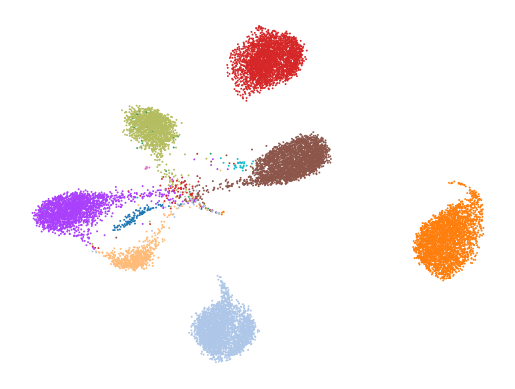

In [10]:
import matplotlib.pyplot as plt

sc.pp.neighbors(adata, use_rep='cell_embeddings')
sc.tl.umap(adata)
sc.pl.umap(adata,
           title='',
           frameon=False,
           legend_loc='',
           legend_fontsize='xx-small',
           save=f"_stFormer_{slide}.pdf",
           color='celltype')

In [11]:
import scib

adata.obs['batch'] = [1]*adata.shape[0]

results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        label_key='celltype',
        batch_key='batch',
        embed="cell_embeddings",
        silhouette_=True,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
    )

result_dict = results[0].to_dict()

/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/shcao/miniconda3/lib/python3.11/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/home/shcao/miniconda3/lib/python3.11/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register

NMI...
ARI...
Silhouette score...


In [12]:
result_dict
# ACH005: NMI 0.953, ARI 0.957
# 10X001: NMI 0.973, ARI 0.984
# ACH002: NMI 0.981, ARI 0.9913
# 10X009: NMI 0.986, ARI 0.994
# ACH006: NMI 0.972, ARI 0.980
# ACH007: NMI 0.919, ARI 0.901
# 10X0017: NMI 0.935, ARI 0.831
# 10X0025: NMI 0.990, ARI 0.995
# 10X0020: NMI 0.987, ARI 0.994

{'NMI_cluster/label': 0.9873320325330928,
 'ARI_cluster/label': 0.9937332222735867,
 'ASW_label': 0.5613320097327232,
 'ASW_label/batch': nan,
 'PCR_batch': nan,
 'cell_cycle_conservation': nan,
 'isolated_label_F1': nan,
 'isolated_label_silhouette': nan,
 'graph_conn': nan,
 'kBET': nan,
 'iLISI': nan,
 'cLISI': nan,
 'hvg_overlap': nan,
 'trajectory': nan}